## Mixing long-term and short-term optimization targets

In energy, we typically face very short-term optimization tasks (e.g. 15min intervals in power) as well as long-term effects such as saisonality. Bringing both together in optimization can easily make complexity explode -- if we optimize all assets on the most granular time grid. In our approach we allow all assets bring along their own time-scale, which may be different from the time-scale that is used on portfolio level.

In this example we explain the feature using a rather simple example:
* power market with hourly prices that exhibit an hourly as well as a seasonal structure
* a short-term storage such as a smaller pump storage or a battery that is optimized hourly on a daily basis - but not across more than a week
* a long-term storage such as a high-volume hydro reservoir that is optimized across the whole seaon on a biweekly basis

## Some prerequisites
### Basics

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import eaopack as eao
import matplotlib.pyplot as plt

### Define portfolio

We use three different assets:
* Market: a simple contract with a given market price
* Short-term storage, acting on an hourly basis. We reduce the complexity by enforcing that the optimization is done for every day, but not across weeks
* Long-term storage acting on a weekly level for the whole season: We reduce complexity by assuming the same (here flat) profile for all hours within two weeks

Note: For sake of clarity in the charts we do the optimization on daily granularity. Finer overall granularity (e.g. hours) is defined on portfolio level in the timegrid


In [2]:
start = dt.date(2021,1,1)
end   = dt.date(2021,12,31)

# the basic setup
node = eao.assets.Node('node')
timegrid = eao.assets.Timegrid(start, end, freq = 'd')
market = eao.assets.SimpleContract(name = 'market', price = 'price', nodes = node ,
                min_cap= -1000., max_cap=1000., start = start, end = end)
# daily flex
st = eao.assets.Storage('ST storage', nodes = node, \
        start=start, end=end, size=10, \
        cap_in=2/24, cap_out=2/24, start_level=5, end_level=5, \
        block_size= 'W')
# weekly flex
lt = eao.assets.Storage('LT storage', nodes = node, \
        start=start, end=end, size=500, \
        cap_in=2/24, cap_out=2/24, start_level=100, end_level=100, \
        freq = '14d')

# price with seasonal and daily pattern
prices ={'price': 10*np.sin(np.linspace(0,2*np.pi, timegrid.T)) \
                + 2*np.sin(np.linspace(0,7*12*np.pi, timegrid.T)) \
                + 2*np.sin(np.linspace(0,7**24*2*np.pi, timegrid.T))}

portf = eao.portfolio.Portfolio([market, st, lt])

The below network chart shows the setup of the portfolio. 

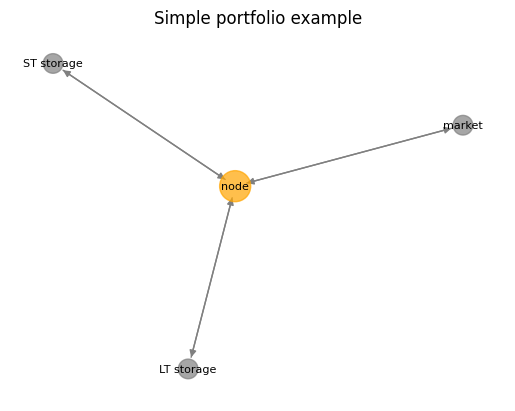

In [3]:
eao.network_graphs.create_graph(portf = portf, title = 'Simple portfolio example')

## Perform the optimization

In [4]:
op    = portf.setup_optim_problem(prices, timegrid)
res = op.optimize()
out = eao.io.extract_output(portf, op, res, prices)

## Create charts and interpret the results

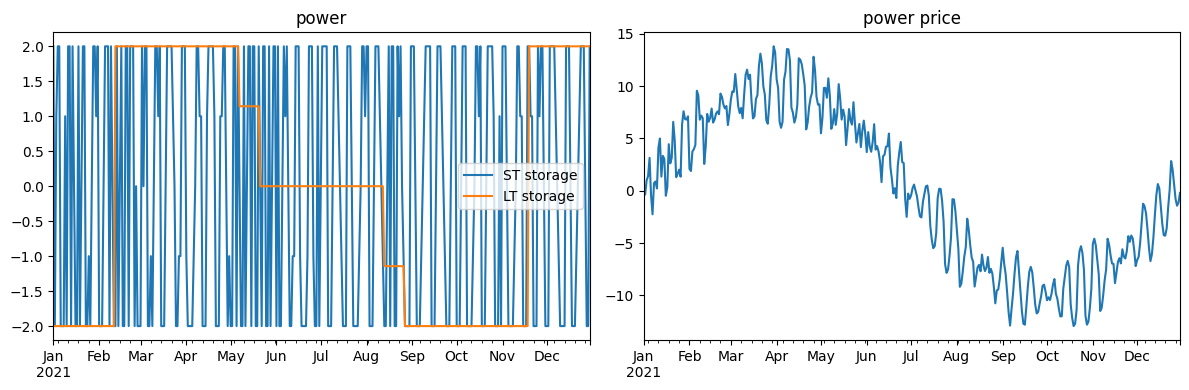

In [5]:
fig, ax = plt.subplots(1,2, tight_layout = True, figsize=(12,4))
out['dispatch'][['ST storage', 'LT storage']].plot(ax = ax[0], style = '-')
out['prices']['input data: price'].plot(ax = ax[1], style = '-')
ax[0].set_title('power')
ax[1].set_title('power price')
plt.show()
